# Setup Python Libraries

In [1]:
import os
import time
import datetime

import pandas as pd
import numpy as np
import random
import pickle

from xgboost import XGBRegressor
from sklearn import model_selection
from sklearn import metrics
from sklearn.utils.validation import check_is_fitted

import matplotlib.pyplot as plt

plt.style.use('ggplot')

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# Load our Trained Models

Model parameters were optimized during the cross-validation phase of our project. Due to the large size of our feature space, it takes a long time for our models to train on the training data. We decided to save the model instead and include the .json representation to make it easy to load and reproduce our results.

In [2]:
# load our trained XGBoost models
XGBCombinedmodel = XGBRegressor()
XGBCombinedmodel.load_model("XGBCombinedmodel.json")

XGBCensusmodel = XGBRegressor()
XGBCensusmodel.load_model("XGBCensusmodel.json")

XGBEmbedmodel = XGBRegressor()
XGBEmbedmodel.load_model("XGBEmbedmodel.json")

# Load in test set and evaluate

In [3]:
test = pd.read_csv("data/testing_set.csv")
trEmbed = pd.read_csv("data/doc2vecembeds.csv")

temp = test[["STATE","COUNTY","YEAR","Violentcrime"]]
trJustEmbed = trEmbed.merge(temp,on=["STATE","COUNTY","YEAR"])

test = test.merge(trEmbed,on=["STATE","COUNTY","YEAR"])

census = pd.read_csv("data/testing_set.csv")

colsCensus = list(census.drop(["STATE","COUNTY","YEAR","Violentcrime"],axis=1).columns)
Xcensus = census.drop(["STATE","COUNTY","YEAR","Violentcrime"],axis=1).to_numpy()
Ycensus = census["Violentcrime"].to_numpy()
Ycensus = np.log(Ycensus+1)

colsCombined = list(test.drop(["STATE","COUNTY","YEAR","Violentcrime","Unnamed: 0","NUMEXAMPLES"],axis=1).columns)
Xcombined = test.drop(["STATE","COUNTY","YEAR","Violentcrime","Unnamed: 0","Unnamed: 0.1","NUMEXAMPLES"],axis=1).to_numpy()
Ycombined = test["Violentcrime"].to_numpy()
Ycombined = np.log(Ycombined+1)

colsEmbed = list(trJustEmbed.drop(["STATE","COUNTY","YEAR","Violentcrime","Unnamed: 0","NUMEXAMPLES"],axis=1).columns)
Xembed = trJustEmbed.drop(["STATE","COUNTY","YEAR","Violentcrime","Unnamed: 0", "Unnamed: 0.1","NUMEXAMPLES"],axis=1).to_numpy()
Yembed = trJustEmbed["Violentcrime"].to_numpy()
Yembed = np.log(Yembed+1)

pd.Series(np.exp(Ycensus)-1).describe()

count     419.000000
mean      284.847255
std       775.300760
min         0.000000
25%        35.000000
50%       104.000000
75%       284.500000
max      9209.000000
dtype: float64

### XGBoost Combined

r2:  0.5517255773758577
mae:  134.73324911662672


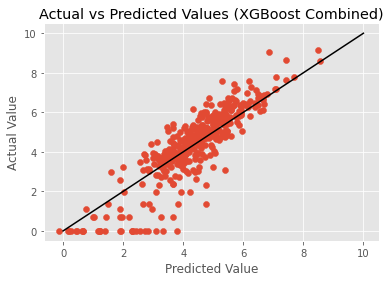

In [4]:
y_pred_1 = XGBCombinedmodel.predict(Xcombined)
r2 = metrics.r2_score(np.exp(Ycombined), np.exp(y_pred_1))
print("r2: ",r2)
mae = metrics.mean_absolute_error(np.exp(Ycombined),np.exp(y_pred_1))
print("mae: ",mae)
plt.scatter(y_pred_1,Ycombined)
plt.title("Actual vs Predicted Values (XGBoost Combined)")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.plot([0,10],[0,10],color="black")
plt.show()

### XGBoost Census

r2:  0.8244912122730572
mae:  99.23964780768229


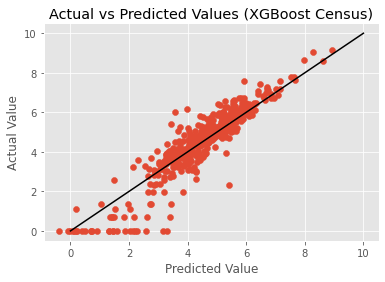

In [5]:
y_pred_2 = XGBCensusmodel.predict(Xcensus)
r2 = metrics.r2_score(np.exp(Ycensus), np.exp(y_pred_2))
print("r2: ",r2)
mae = metrics.mean_absolute_error(np.exp(Ycensus),np.exp(y_pred_2))
print("mae: ",mae)
plt.scatter(y_pred_2,Ycombined)
plt.title("Actual vs Predicted Values (XGBoost Census)")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.plot([0,10],[0,10],color="black")
plt.show()

## XGBoost Embed

r2:  -0.0892731321389475
mae:  274.9912647014586


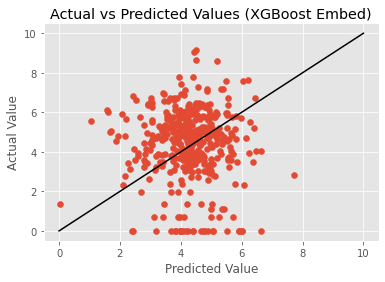

In [6]:
y_pred_5 = XGBEmbedmodel.predict(Xembed)
r2 = metrics.r2_score(np.exp(Ycensus), np.exp(y_pred_5))
print("r2: ",r2)
mae = metrics.mean_absolute_error(np.exp(Ycensus),np.exp(y_pred_5))
print("mae: ",mae)
plt.scatter(y_pred_5,Ycombined)
plt.title("Actual vs Predicted Values (XGBoost Embed)")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.plot([0,10],[0,10],color="black")
plt.show()

## Baseline

r2:  -0.002510120438981911
mae:  286.3114325942721


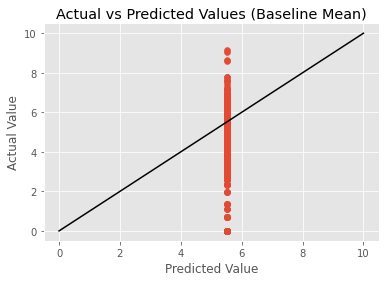

In [7]:
y_pred_7 = np.repeat(np.log(247.050213),len(Ycensus))
r2 = metrics.r2_score(np.exp(Ycensus), np.exp(y_pred_7))
print("r2: ",r2)
mae = metrics.mean_absolute_error(np.exp(Ycensus),np.exp(y_pred_7))
print("mae: ",mae)
plt.scatter(y_pred_7,Ycensus)
plt.title("Actual vs Predicted Values (Baseline Mean)")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.plot([0,10],[0,10],color="black")
plt.show()

## Evaluation

#### Plot Residuals

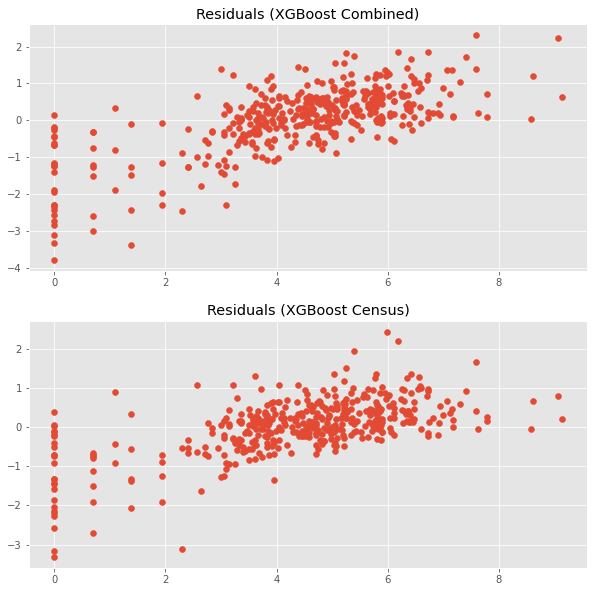

In [8]:
resid1 = Ycensus - y_pred_1
resid2 = Ycensus - y_pred_2

fig, axs = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(10)

axs[0].scatter(Ycensus,resid1)
axs[0].set_title("Residuals (XGBoost Combined)")


axs[1].scatter(Ycensus,resid2)
axs[1].set_title("Residuals (XGBoost Census)")


plt.show()

## Save Predictions
Since we want to conduct some of the evaluation outside of this environment, we save the model predictions and actual values.

In [9]:
finalPred = pd.DataFrame()

finalPred["actual"] = Ycensus
finalPred["XGCensus"] = y_pred_2
finalPred["XGCombined"] = y_pred_1

finalPred.to_csv("finalPred.csv")